## 1. 패키지, 데이터 불러오기

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

games = pd.read_csv("Data/games.csv", parse_dates=["GAME_DATE_EST"])
details = pd.read_csv("Data/games_details.csv", low_memory=False)
teams = pd.read_csv("Data/teams.csv")
ranking = pd.read_csv("Data/ranking.csv")
player = pd.read_csv("Data/players.csv")

### 필요로 하는 CSV 파일의 컬럼들
---
#### 송원우
- games.csv: 'GAME_ID", "SEASON"
- games_details.csv: 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS', 'PLUS_MINUS', 'FGM', 'FGA', 'FG3M', 'FTA'
---
#### 김규열
- games.csv: "GAME_ID", "GAME_DATE_EST", "HOME_TEAM_ID", "VISITOR_TEAM_ID", "PTS_home", "PTS_away", "SEASON"
- games_details.csv: "GAME_ID", "TEAM_ID", "TEAM_ABBREVIATION", "PLAYER_ID", "PLAYER_NAME","MIN", "PLUS_MINUS", "FG_PCT", "FG3_PCT", "FT_PCT", "COMMENT", "START_POSITION"

## 2. 분석관점

### 분석 목표
2014-2015시즌 우승의 이유를 파악하고, 이해관계자인 단장에게 맞는 조언을 할 수 있음. 우승에 기여한 요인을 이해할 수 있어, 역할 별로 실행 가능한 전략과 의사결정 방향을 제시할 수 있음.

### 핵심 분석 영역 (2가지)
##### 송원우: 우승 시즌을 기준으로, 팀의 핵심 포지션 선수들이 리그 전체 기준에서               얼마나 경쟁력을 갖추게 되었는가?
##### 김규열: 우승 시즌에는 상대팀이 달라져도 선수들이 비슷한 수준의 활약을 했을까?

## 3. 데이터 이해

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     26651 non-null  datetime64[ns]
 1   GAME_ID           26651 non-null  int64         
 2   GAME_STATUS_TEXT  26651 non-null  object        
 3   HOME_TEAM_ID      26651 non-null  int64         
 4   VISITOR_TEAM_ID   26651 non-null  int64         
 5   SEASON            26651 non-null  int64         
 6   TEAM_ID_home      26651 non-null  int64         
 7   PTS_home          26552 non-null  float64       
 8   FG_PCT_home       26552 non-null  float64       
 9   FT_PCT_home       26552 non-null  float64       
 10  FG3_PCT_home      26552 non-null  float64       
 11  AST_home          26552 non-null  float64       
 12  REB_home          26552 non-null  float64       
 13  TEAM_ID_away      26651 non-null  int64         
 14  PTS_away          2655

In [4]:
games.isnull().sum()

GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away         99
FG3_PCT_away        99
AST_away            99
REB_away            99
HOME_TEAM_WINS       0
dtype: int64

In [7]:
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [5]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668628 entries, 0 to 668627
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            668628 non-null  int64  
 1   TEAM_ID            668628 non-null  int64  
 2   TEAM_ABBREVIATION  668628 non-null  object 
 3   TEAM_CITY          668628 non-null  object 
 4   PLAYER_ID          668628 non-null  int64  
 5   PLAYER_NAME        668628 non-null  object 
 6   NICKNAME           53037 non-null   object 
 7   START_POSITION     255765 non-null  object 
 8   COMMENT            109689 non-null  object 
 9   MIN                558938 non-null  object 
 10  FGM                558938 non-null  float64
 11  FGA                558938 non-null  float64
 12  FG_PCT             558938 non-null  float64
 13  FG3M               558938 non-null  float64
 14  FG3A               558938 non-null  float64
 15  FG3_PCT            558938 non-null  float64
 16  FT

In [6]:
details.isnull().sum()

GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
NICKNAME             615591
START_POSITION       412863
COMMENT              558939
MIN                  109690
FGM                  109690
FGA                  109690
FG_PCT               109690
FG3M                 109690
FG3A                 109690
FG3_PCT              109690
FTM                  109690
FTA                  109690
FT_PCT               109690
OREB                 109690
DREB                 109690
REB                  109690
AST                  109690
STL                  109690
BLK                  109690
TO                   109690
PF                   109690
PTS                  109690
PLUS_MINUS           133351
dtype: int64

In [8]:
details.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


## 4. 전처리

### 송원우

In [10]:
games['SEASON']

0        2022
1        2022
2        2022
3        2022
4        2022
         ... 
26646    2014
26647    2014
26648    2014
26649    2014
26650    2014
Name: SEASON, Length: 26651, dtype: int64

99개의 정체 확인

In [11]:
error_games = games[games['PTS_home'].isnull()]

print(error_games['GAME_STATUS_TEXT'].value_counts())

GAME_STATUS_TEXT
Final    99
Name: count, dtype: int64


상위 5개 행만 확인

In [12]:
print(error_games[['GAME_DATE_EST', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID']].head())

      GAME_DATE_EST GAME_STATUS_TEXT  HOME_TEAM_ID
19175    2003-10-24            Final    1610612753
19176    2003-10-24            Final    1610612737
19177    2003-10-24            Final    1610612738
19178    2003-10-24            Final    1610612759
19179    2003-10-24            Final    1610612749


경기가 끝난상태인데 기록이 없는 것이므로 삭제 진행

In [13]:
clean_games = games.dropna(subset = ["PTS_home"])

print(clean_games.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26552 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     26552 non-null  datetime64[ns]
 1   GAME_ID           26552 non-null  int64         
 2   GAME_STATUS_TEXT  26552 non-null  object        
 3   HOME_TEAM_ID      26552 non-null  int64         
 4   VISITOR_TEAM_ID   26552 non-null  int64         
 5   SEASON            26552 non-null  int64         
 6   TEAM_ID_home      26552 non-null  int64         
 7   PTS_home          26552 non-null  float64       
 8   FG_PCT_home       26552 non-null  float64       
 9   FT_PCT_home       26552 non-null  float64       
 10  FG3_PCT_home      26552 non-null  float64       
 11  AST_home          26552 non-null  float64       
 12  REB_home          26552 non-null  float64       
 13  TEAM_ID_away      26552 non-null  int64         
 14  PTS_away          26552 non

In [14]:
error_min = details[details['MIN'].isnull()]

print(error_min['COMMENT'].value_counts().head())

COMMENT
DNP - Coach's Decision                      58054
DNP - Coach's Decision                      30547
DND - Injury/Illness                         1267
DNP - Injury/Illness                         1161
DNP - Injury/Illness                         1151
Name: count, dtype: int64


- 결측치1 : 109690건의 데이터부터 전처리 시작
- MIN 출전시간이 없는 선수 왜 그런지 확인
- 혹시나 점수 기록이 있는지 확인해보았다.

In [15]:
print(error_min['PTS'].describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: PTS, dtype: float64


기록이 없는 선수들이므로 삭제(분석 관점이 선수들의 평균 기록 비교이기 때문)

In [16]:
clean_details = details.dropna(subset = 'MIN')

결측치2 : START_POSITION이 없는 41만건 확인,
벤치에 있는 선수여서 선발 포지션이 없는지 확인

In [17]:
if_bench = details[(details['START_POSITION'].isnull())]

if_bench = details[(details['MIN'].notnull())]

if_bench.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


벤치 선수의 출전 기록 확인 후
선발은 양팀 합쳐서 10명인데 10이 아닌 경기도 있을 수 있음

In [18]:
starters_count = clean_details.groupby("GAME_ID")["START_POSITION"].count()

bad_games = starters_count[starters_count != 10].index

print(len(starters_count))
print(len(bad_games))

print(1024/26523*100)

26523
1024
3.860800060325001


중복데이터이거나, 입력 누락, 선발이 0의 경우 아무 기록도 없기 때문에 삭제가 가능하다고 판단
평균에 큰 영향을 안끼칠거 같아 1024개 삭제 진행

In [19]:
clean_details = clean_details[~clean_details['GAME_ID'].isin(bad_games)].copy()

선발은 아니었지만 경기기록이 있는 선수는 벤치로 분류

In [20]:
clean_details['START_POSITION'] = clean_details['START_POSITION'].fillna('bench')

In [21]:
clean_details.head(20)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0
5,22200477,1610612759,SAS,San Antonio,1628380,Zach Collins,Zach,bench,NaN,18:04,...,1.0,1.0,2.0,2.0,0.0,0.0,0.0,3.0,6.0,-13.0
6,22200477,1610612759,SAS,San Antonio,203926,Doug McDermott,Doug,bench,NaN,16:55,...,1.0,3.0,4.0,1.0,0.0,0.0,1.0,0.0,5.0,-10.0
7,22200477,1610612759,SAS,San Antonio,1626196,Josh Richardson,Josh,bench,NaN,21:20,...,1.0,2.0,3.0,3.0,0.0,0.0,1.0,2.0,14.0,-2.0
8,22200477,1610612759,SAS,San Antonio,1631103,Malaki Branham,Malaki,bench,NaN,21:10,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,9.0,-6.0
9,22200477,1610612759,SAS,San Antonio,1628966,Keita Bates-Diop,Keita,bench,NaN,9:16,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,-1.0


In [22]:
print(clean_games['SEASON'].unique())

[2022 2021 2020 2019 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004
 2003 2018 2017 2016 2015 2014]


In [23]:
merged_df = pd.merge(clean_details, clean_games[['GAME_ID', 'SEASON']], on = 'GAME_ID', how = 'left')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533657 entries, 0 to 533656
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            533657 non-null  int64  
 1   TEAM_ID            533657 non-null  int64  
 2   TEAM_ABBREVIATION  533657 non-null  object 
 3   TEAM_CITY          533657 non-null  object 
 4   PLAYER_ID          533657 non-null  int64  
 5   PLAYER_NAME        533657 non-null  object 
 6   NICKNAME           43396 non-null   object 
 7   START_POSITION     533657 non-null  object 
 8   COMMENT            0 non-null       object 
 9   MIN                533657 non-null  object 
 10  FGM                533657 non-null  float64
 11  FGA                533657 non-null  float64
 12  FG_PCT             533657 non-null  float64
 13  FG3M               533657 non-null  float64
 14  FG3A               533657 non-null  float64
 15  FG3_PCT            533657 non-null  float64
 16  FT

- 클린 데이터 merge 진행
- clean_games 에서 시즌 정보를 가져와야함
- GAME_ID를 기준으로 Left 진행

In [24]:
def min_to_float(x) :
    try :
        if isinstance(x, str) and ':' in x :
            m, s = x.split(':')
            return float(m) + float(s)/60
        else :
            return float(x)
    except :
        return 0.0

merged_df['PLAY_TIME'] = merged_df['MIN'].apply(min_to_float)
merged_df.head(10)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON,PLAY_TIME
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0,2022,18.100000
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0,2022,31.016667
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0,2022,21.700000
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0,2022,30.333333
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0,2022,27.733333
5,22200477,1610612759,SAS,San Antonio,1628380,Zach Collins,Zach,bench,NaN,18:04,...,2.0,2.0,0.0,0.0,0.0,3.0,6.0,-13.0,2022,18.066667
6,22200477,1610612759,SAS,San Antonio,203926,Doug McDermott,Doug,bench,NaN,16:55,...,4.0,1.0,0.0,0.0,1.0,0.0,5.0,-10.0,2022,16.916667
7,22200477,1610612759,SAS,San Antonio,1626196,Josh Richardson,Josh,bench,NaN,21:20,...,3.0,3.0,0.0,0.0,1.0,2.0,14.0,-2.0,2022,21.333333
8,22200477,1610612759,SAS,San Antonio,1631103,Malaki Branham,Malaki,bench,NaN,21:10,...,0.0,0.0,0.0,0.0,1.0,2.0,9.0,-6.0,2022,21.166667
9,22200477,1610612759,SAS,San Antonio,1628966,Keita Bates-Diop,Keita,bench,NaN,9:16,...,1.0,0.0,0.0,0.0,0.0,1.0,4.0,-1.0,2022,9.266667


- MIN 출전시간이 문자로 되어 있어 숫자로 변환해야함
- 숫자로 만드는 함수 먼저 진행
- 파생컬럼 'PLAY_TIME' 생성

In [25]:
nba_15 = merged_df[merged_df['SEASON'] == 2014].copy()

gsw_15 = nba_15[nba_15['TEAM_ABBREVIATION'] == 'GSW'].copy()

gsw_15.head(10)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON,PLAY_TIME
448287,41400406,1610612744,GSW,Golden State,2738,Andre Iguodala,NaN,F,NaN,36:21,...,5.0,5.0,2.0,0.0,0.0,4.0,25.0,14.0,2014,36.350000
448288,41400406,1610612744,GSW,Golden State,203084,Harrison Barnes,NaN,F,NaN,35:27,...,2.0,2.0,1.0,0.0,0.0,3.0,9.0,-2.0,2014,35.450000
448289,41400406,1610612744,GSW,Golden State,203110,Draymond Green,NaN,C,NaN,41:28,...,11.0,10.0,3.0,1.0,3.0,5.0,16.0,11.0,2014,41.466667
448290,41400406,1610612744,GSW,Golden State,202691,Klay Thompson,NaN,G,NaN,24:40,...,5.0,2.0,0.0,1.0,2.0,6.0,5.0,2.0,2014,24.666667
448291,41400406,1610612744,GSW,Golden State,201939,Stephen Curry,NaN,G,NaN,43:06,...,6.0,8.0,3.0,0.0,3.0,3.0,25.0,14.0,2014,43.100000
448292,41400406,1610612744,GSW,Golden State,2733,Shaun Livingston,NaN,bench,NaN,32:19,...,3.0,0.0,0.0,1.0,0.0,3.0,10.0,3.0,2014,32.316667
448293,41400406,1610612744,GSW,Golden State,203105,Festus Ezeli,NaN,bench,NaN,10:56,...,4.0,0.0,0.0,1.0,1.0,2.0,10.0,5.0,2014,10.933333
448294,41400406,1610612744,GSW,Golden State,2571,Leandro Barbosa,NaN,bench,NaN,14:30,...,3.0,1.0,2.0,0.0,0.0,1.0,5.0,-9.0,2014,14.500000
448295,41400406,1610612744,GSW,Golden State,101135,David Lee,NaN,bench,NaN,1:13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2014,1.216667
448313,41400405,1610612744,GSW,Golden State,2738,Andre Iguodala,NaN,F,NaN,42:28,...,8.0,7.0,3.0,0.0,0.0,2.0,14.0,16.0,2014,42.466667


- 14-15 시즌 정보를 필요로 하기 때문에
- 시즌 전체와 팀 정보 분류
(별칭은 팀에서 정한 기준으로 작성 14-15 시즌이면 15로 지정)

궁금증 발생!

선발 출장 수 / 벤치 출장 수
    선발 시 어떤 포지션으로 출전 했는지? - 시간 남으면 하자..

출장 경기 수

우리팀만 분류하기

### 김규열

### Details 테이블 전처리
#### 전처리 필요가 없는 칼럼
- GAME_ID, TEAM_ID,TEAM_ABBREVIATION, PLAYER_ID, PLAYER_NAME

#### 전처리 필요한 칼럼
- START_POSITION(카테고리 화, null처리), MIN(min.decimal, null 처리), PLUS_MINUS(Null값 처리), FGM, FGA, FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT,OREB, DREB, REB, AST, STL, BLK, TO, PF, PTS(Null 처리)

In [37]:
# clean_details 생성
clean_details = details.copy()

In [38]:
# 필요한 칼럼들만 선택
clean_details = clean_details[
    ["GAME_ID", "TEAM_ID", "TEAM_ABBREVIATION", "PLAYER_ID", "PLAYER_NAME",
     "START_POSITION", "MIN", "PLUS_MINUS", "FGM", "FGA", "FG_PCT", "FG3M",
     "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT", "OREB", "DREB", "REB", "AST",
     "STL", "BLK", "TO", "PF", "PTS"]
].copy()

- START_POSITION 칼럼은 한 경기당 10명씩 지정이 되어야 함.
- 밑에 코드에서 한 경기당 10명이 아닌 경기들을 확인.

In [39]:
# START_POSITION 칼럼 이상데이터들 확인
bad_games = (
    clean_details
    .groupby("GAME_ID")["START_POSITION"]
    .apply(lambda x: x.notna().sum())
    .loc[lambda x: x != 10]
)
bad_game_ids = bad_games.index
clean_details[clean_details["GAME_ID"].isin(bad_game_ids)]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_ID,PLAYER_NAME,START_POSITION,MIN,PLUS_MINUS,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
65896,22000069,1610612763,MEM,1629634,Brandon Clarke,F,31:35,12.0,6.0,11.0,...,1.000,1.0,3.0,4.0,3.0,0.0,2.0,2.0,3.0,15.0
65897,22000069,1610612763,MEM,203937,Kyle Anderson,F,29:10,25.0,7.0,15.0,...,1.000,1.0,10.0,11.0,5.0,2.0,1.0,0.0,2.0,18.0
65898,22000069,1610612763,MEM,202685,Jonas Valanciunas,C,25:47,17.0,6.0,9.0,...,0.500,3.0,7.0,10.0,1.0,1.0,0.0,2.0,3.0,14.0
65899,22000069,1610612763,MEM,1628415,Dillon Brooks,G,28:12,18.0,8.0,17.0,...,0.000,1.0,2.0,3.0,2.0,3.0,1.0,5.0,4.0,21.0
65900,22000069,1610612763,MEM,1626145,Tyus Jones,G,28:59,25.0,3.0,7.0,...,0.000,0.0,1.0,1.0,12.0,2.0,0.0,1.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668623,11200005,1610612743,DEN,202706,Jordan Hamilton,NaN,19,NaN,4.0,9.0,...,0.857,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0
668624,11200005,1610612743,DEN,202702,Kenneth Faried,NaN,23,NaN,7.0,11.0,...,1.000,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0
668625,11200005,1610612743,DEN,201585,Kosta Koufos,NaN,15,NaN,3.0,7.0,...,0.000,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0
668626,11200005,1610612743,DEN,202389,Timofey Mozgov,NaN,19,NaN,1.0,1.0,...,0.000,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0


In [40]:
# 10명이 아닌 경기들의 START_POSITION 개수 확인
bad_games = (
    clean_details
    .groupby("GAME_ID")["START_POSITION"]
    .apply(lambda x: x.notna().sum())
    .loc[lambda x: x != 10]
)
bad_games

GAME_ID
10300001     0
10300002     0
10300003     0
10300004     0
10300005     0
            ..
22000073    12
22000074    11
22000076    11
22000077    11
22000078    13
Name: START_POSITION, Length: 1024, dtype: int64

In [41]:
bad_games.value_counts()

START_POSITION
0     958
11     25
12     19
13     10
9       6
14      3
15      2
16      1
Name: count, dtype: int64

- 10명이 정상적으로 적히지 않은 경기들은 불량데이터로 판단하여 drop하기로 결정.
- 특히나, 불량 경기의 수가 적은 수이기에 drop으로 하는데 문제가 없다고 판단.

In [42]:
# bad_games 데이터 삭제
clean_details = clean_details[
    ~clean_details["GAME_ID"].isin(bad_games.index)
].copy()

In [43]:
# Check that all remaining games have exactly 10 starters
check = (
    clean_details
    .groupby("GAME_ID")["START_POSITION"]
    .apply(lambda x: x.notna().sum())
)
check.value_counts()

START_POSITION
10    25499
Name: count, dtype: int64

In [44]:
# Start_position 카테고리화
clean_details["START_POSITION"] = clean_details["START_POSITION"].astype("category")

In [45]:
# Start_position 처리되었는지 확인
clean_details["START_POSITION"].dtype

CategoricalDtype(categories=['C', 'F', 'G'], ordered=False, categories_dtype=object)

In [46]:
clean_details["START_POSITION"].value_counts(dropna=False)

START_POSITION
NaN    387923
F      101996
G      101996
C       50998
Name: count, dtype: int64

- 남아있는 NaN은 플레이했지만, 벤치에 앉아있었던 인원으로 생각하여 NaN을 '벤치'로 처리
- "START_POSITION"칼럼이 본 분석에 필요없기에 필요하신 팀원 원우님이 처리하기로 함.

In [47]:
# MIN 처리 전 확인 1
clean_details["MIN"].apply(type).value_counts()

MIN
<class 'str'>      533563
<class 'float'>    109350
Name: count, dtype: int64

In [48]:
# MIN 처리 전 확인 2
clean_details[
    clean_details["MIN"].apply(type) == str]["MIN"].value_counts().head(10)

MIN
12:00    1782
24:00     755
27:54     310
21:28     307
22:40     307
25:22     304
29:41     303
25:44     302
25:20     300
22:05     300
Name: count, dtype: int64

In [49]:
# MIN 처리 전 확인 3
clean_details["MIN"].value_counts(dropna=False)

MIN
NaN      109350
12:00      1782
24:00       755
27:54       310
21:28       307
          ...  
51:18         1
54:20         1
57:24         1
51:42         1
52:32         1
Name: count, Length: 3731, dtype: int64

In [50]:
# MIN into float
def minutes_to_decimal(x):
    if pd.isna(x):
        return pd.NA

    if isinstance(x, (int, float)):
        return float(x)

    s = str(x).strip()

    if ":" in s:
        mins, secs = s.split(":")
        return float(mins) + float(secs) / 60

    return float(s)

clean_details["MIN_DECIMAL"] = clean_details["MIN"].apply(minutes_to_decimal)

원우님과 동일하게 MIN칼럼을 전처리해서 MIN_DECIMAL로 생성

In [51]:
# GSW의 자료에 null값 확인 -> 전부 부상이나 특정 이유로 불참.
cols_to_check = ["MIN", "FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT",
                 "FTM", "FTA", "FT_PCT", "OREB", "DREB", "REB",
                 "AST", "STL", "BLK", "TO", "PF", "PTS"]
null_condition = details[cols_to_check].isna().any(axis=1)
gsw_nulls = details[null_condition & (details["TEAM_ABBREVIATION"] == "GSW")]
(gsw_nulls["COMMENT"].notna() & gsw_nulls["COMMENT"].str.strip().ne("")).all()

np.True_

In [52]:
gsw_nulls_check = details[null_condition & (details["TEAM_ABBREVIATION"] == "GSW")& gsw_nulls["COMMENT"].notna()]
gsw_nulls_check["COMMENT"].value_counts()

COMMENT
DNP - Coach's Decision                      1572
DNP - Coach's Decision                       688
DNP - Injury/Illness                          88
DND - Injury/Illness                          61
DNP - Injury/Illness                          50
                                            ... 
DND - Right Wrist Sprain                       1
DND - Food Poisoning                           1
NWT - Right Wrist Surgery Recovery             1
NWT - Right wrist surgery                      1
NWT - Flu like Symptoms                        1
Name: count, Length: 393, dtype: int64

- Null값들은 전부 DND, NWT, DNP 인것을 확인함. 참여자체를 안했음.
- DNP: 부상이나 특정 이유로 불참
- DND: 해당 선수는 로스터에서 제외되어 경기 출전이 불가능했습니다.
- NWT: 해당 선수는 개인 사정 등으로 경기 당시 팀과 동행하지 않았습니다.

In [53]:
# 경기에 참여하지 않은 선수들의 데이터에 대한 자료는 drop
cols_to_check = ["MIN", "FGM", "FGA", "FG_PCT", "FG3M", "FG3A", "FG3_PCT",
                 "FTM", "FTA", "FT_PCT", "OREB", "DREB", "REB",
                 "AST", "STL", "BLK", "TO", "PF", "PTS", "PLUS_MINUS"]
clean_details = clean_details.dropna(subset=cols_to_check, how="all")

In [54]:
# drop한 결과 확인
before = len(details)
after = len(clean_details)
print(f"{before - after} rows dropped.")

135065 rows dropped.


In [55]:
# PLUS_MINUS 칼럼 확인
clean_details[clean_details["PLUS_MINUS"].isnull()]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_ID,PLAYER_NAME,START_POSITION,MIN,PLUS_MINUS,FGM,FGA,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,MIN_DECIMAL


In [56]:
# PLUS_MINUS 칼럼 중에 가능한 것들만 나타내는 파생칼럼 생성.
clean_details["PLUS_MINUS_AVAILABLE"] = clean_details["PLUS_MINUS"].notna()
clean_details["PLUS_MINUS_AVAILABLE"].value_counts()

PLUS_MINUS_AVAILABLE
True    533563
Name: count, dtype: int64

In [57]:
# PLUS_MINUS 칼럼 평균이 0에 근접한 것을 확인함.
clean_details["PLUS_MINUS"].describe()

count    533563.000000
mean          0.000079
std          10.661169
min         -57.000000
25%          -7.000000
50%           0.000000
75%           6.000000
max          57.000000
Name: PLUS_MINUS, dtype: float64

In [58]:
clean_details["PLUS_MINUS"] = clean_details["PLUS_MINUS"].fillna(0)
clean_details["PLUS_MINUS"].isnull().sum()

np.int64(0)

### games 테이블 전처리
#### 전처리 필요가 없는 칼럼
GAME_ID, HOME_TEAM_ID, VISITOR_TEAM_ID
#### 전처리 필요한 칼럼
- GAME_DATE_EST(date), PTS_home(Null처리), PTS_away(Null처리), SEASON(Null처리)

In [59]:
# clean_games 생성
clean_games= games.copy()

In [60]:
# 필요한 칼럼들만 선택
clean_games = clean_games[
    ["GAME_ID", "GAME_DATE_EST", "HOME_TEAM_ID", "VISITOR_TEAM_ID",
     "PTS_home", "PTS_away", "SEASON"]]

In [61]:
clean_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GAME_ID          26651 non-null  int64         
 1   GAME_DATE_EST    26651 non-null  datetime64[ns]
 2   HOME_TEAM_ID     26651 non-null  int64         
 3   VISITOR_TEAM_ID  26651 non-null  int64         
 4   PTS_home         26552 non-null  float64       
 5   PTS_away         26552 non-null  float64       
 6   SEASON           26651 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 1.4 MB


In [62]:
# PTS_home 확인 1
clean_games[clean_games["PTS_home"].isnull()]

,GAME_ID,GAME_DATE_EST,HOME_TEAM_ID,VISITOR_TEAM_ID,PTS_home,PTS_away,SEASON
19175,10300116,2003-10-24,1610612753,1610612762,NaN,NaN,2003
19176,10300108,2003-10-24,1610612737,1610612764,NaN,NaN,2003
19177,10300109,2003-10-24,1610612738,1610612751,NaN,NaN,2003
19178,10300113,2003-10-24,1610612759,1610612745,NaN,NaN,2003
19179,10300112,2003-10-24,1610612749,1610612765,NaN,NaN,2003
...,...,...,...,...,...,...,...
19269,10300019,2003-10-09,1610612743,1610612756,NaN,NaN,2003
19270,10300022,2003-10-09,1610612757,1610612758,NaN,NaN,2003
19271,10300013,2003-10-08,1610612759,1610612763,NaN,NaN,2003
19278,10300015,2003-10-08,1610612747,1610612744,NaN,NaN,2003


In [63]:
# PTS_home 확인 2
bad_game_ids = games[
    clean_games.filter(like="_home").isna().all(axis=1)
]["GAME_ID"]

clean_details[clean_details["GAME_ID"].isin(bad_game_ids)].shape

(0, 28)

- 위에 코드에서 details 테이블에 경기내역이 존재하지 않는 games테이블의 데이터임을 확인
- 경기자체의 데이터가 없는 빈껍질 스케줄이기 때문에 drop

In [65]:
# PTS_home, PTS_away, SEASON null인 것들을 drop
clean_games = clean_games.dropna()

In [66]:
# drop 결과 확인
before = len(games)
after = len(clean_games)
print(f"{before - after} rows dropped.")

99 rows dropped.


## 5. EDA & 시각화

### 송원우

In [26]:
nba_15['is_start'] = nba_15['START_POSITION'] != 'bench'
nba_15['is_bench'] = nba_15['START_POSITION'] == 'bench'

start_or_bench = nba_15.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION'])[['is_start', 'is_bench']].sum().reset_index()

start_or_bench['total_play_year'] = start_or_bench['is_start'] + start_or_bench['is_bench']

print(start_or_bench[start_or_bench['TEAM_ABBREVIATION'] == 'GSW'].sort_values('is_start', ascending = False))

              PLAYER_NAME TEAM_ABBREVIATION  is_start  is_bench  \
235       Harrison Barnes               GSW       108         3   
582         Stephen Curry               GSW       108         0   
387         Klay Thompson               GSW       105         0   
173        Draymond Green               GSW       101         7   
35           Andrew Bogut               GSW        89         3   
145             David Lee               GSW        11        58   
439     Marreese Speights               GSW         9        83   
205          Festus Ezeli               GSW         7        61   
29         Andre Iguodala               GSW         7        99   
360        Justin Holiday               GSW         4        68   
568      Shaun Livingston               GSW         2        97   
489         Ognjen Kuzmic               GSW         2        21   
473       Nemanja Nedovic               GSW         1         4   
410       Leandro Barbosa               GSW         1        9

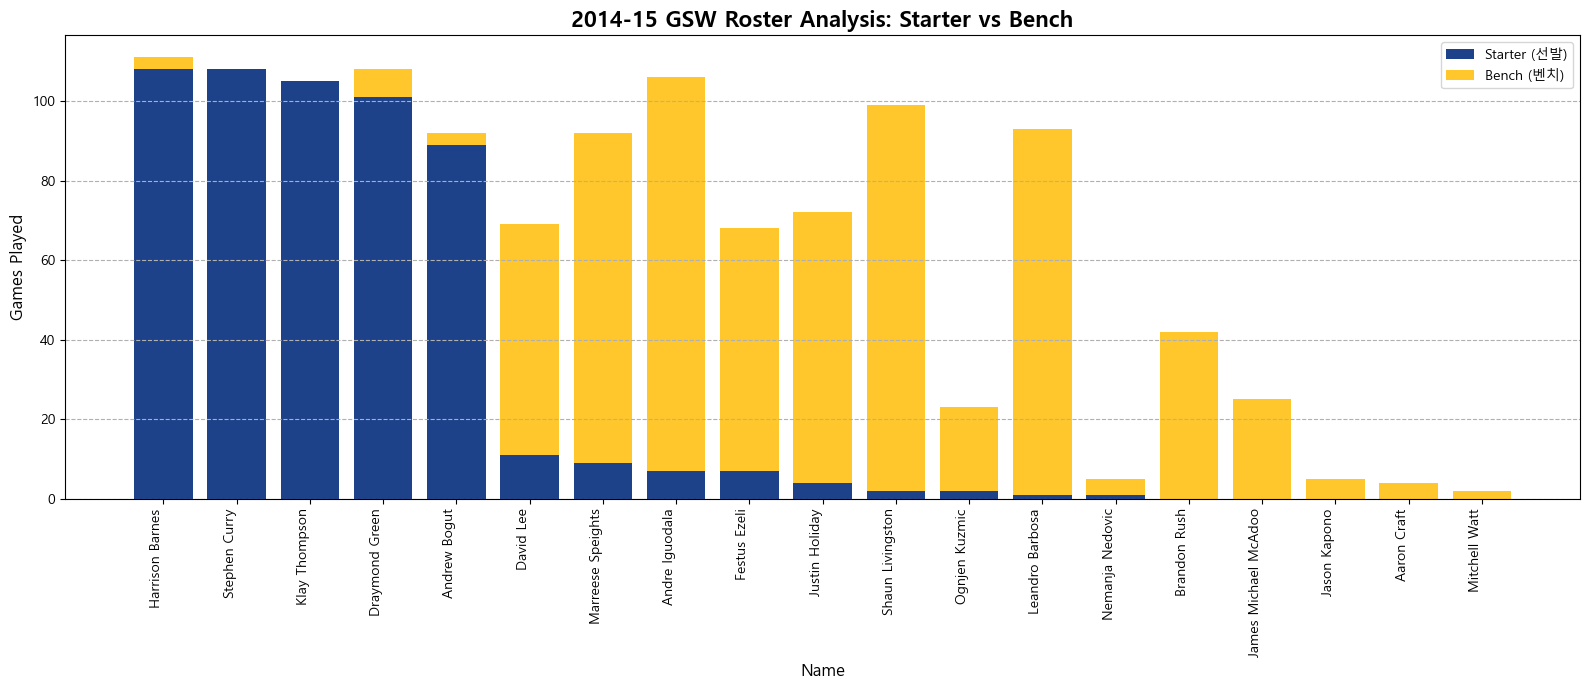

In [28]:
gsw_roster = start_or_bench[start_or_bench['TEAM_ABBREVIATION'] == 'GSW'].sort_values(by=['is_start', 'total_play_year'], ascending=[False, False])

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (16, 7))

players = gsw_roster['PLAYER_NAME']
starts = gsw_roster['is_start']
bench = gsw_roster['is_bench']

gsw_blue = '#1D428A'
gsw_yellow = '#FFC72C'
gsw_slate = '#26282A'

p1 = plt.bar(players, starts, label='Starter (선발)', color=gsw_blue)
p2 = plt.bar(players, bench, bottom=starts, label='Bench (벤치)', color=gsw_yellow)

plt.title('2014-15 GSW Roster Analysis: Starter vs Bench', fontsize=16, fontweight='bold')
plt.ylabel('Games Played', fontsize=12)
plt.xlabel('Name', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=1)

plt.tight_layout()
plt.show()

팀 주전 선수와 리그 상위선수들, 평균과의 비교
    - 공격기준, 수비기준

1차 지표들을 통해 2차 지표 생성

    TS% = PTS / 2(FGA + 0.44 * FTA)
    0.44는 테크니컬 파울이나 앤드원(And-1) 상황을 고려하여 도출된 통계적 계수

    eFG% = FGM + (0.5 * 3PM) / FGA
    3점슛에 가중치 0.5를 줌

    Net Rating : 100 * (OFFRtg - DEFRtg)
        +10 이상이면 리그를 지배하는 수준, 만약 개인기록은 평범하지만 Net Rating이 높다면 보이지 않는 부분에서 팀 승리에 결정적인 역할을 함

In [29]:
df = merged_df
df_2014 = df[(df['SEASON'] == 2014) & (df['START_POSITION'].isin(['G', 'F', 'C']))]

basic_stats = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS', 'PLUS_MINUS', 'FGM', 'FGA', 'FG3M', 'FTA']

player_avg = df_2014.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION', 'START_POSITION'])[basic_stats].mean(numeric_only=True).reset_index()

game_counts = df_2014.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION', 'START_POSITION'])['GAME_ID'].count().reset_index(name='GAME_COUNT')
player_avg = pd.merge(player_avg, game_counts, on=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'START_POSITION'])
player_avg = player_avg[player_avg['GAME_COUNT'] >= 10]

player_avg['eFG%'] = (player_avg['FGM'] + 0.5 * player_avg['FG3M']) / player_avg['FGA'] * 100

player_avg['TS%'] = player_avg['PTS'] / (2 * (player_avg['FGA'] + 0.44 * player_avg['FTA'])) * 100

gsw_players = player_avg[player_avg['TEAM_ABBREVIATION'] == 'GSW']
league_players = player_avg[player_avg['TEAM_ABBREVIATION'] != 'GSW']

gsw_g = gsw_players[gsw_players['START_POSITION'] == 'G'].sort_values('PTS', ascending=False).head(2)
gsw_f = gsw_players[gsw_players['START_POSITION'] == 'F'].sort_values('PTS', ascending=False).head(2)
gsw_c = gsw_players[gsw_players['START_POSITION'] == 'C'].sort_values('PTS', ascending=False).head(1)

top_g = league_players[league_players['START_POSITION'] == 'G'].sort_values('PTS', ascending=False).head(10)
top_f = league_players[league_players['START_POSITION'] == 'F'].sort_values('PTS', ascending=False).head(10)
top_c = league_players[league_players['START_POSITION'] == 'C'].sort_values('PTS', ascending=False).head(5)

gsw_starters = pd.concat([gsw_g, gsw_f, gsw_c])
league_top = pd.concat([top_g, top_f, top_c])

print("GSW 주전 경쟁력")
print(gsw_starters.groupby('START_POSITION').mean(numeric_only=True).round(2))

print("리그 상위권 평균")
print(league_top.groupby('START_POSITION').mean(numeric_only=True).round(2))

GSW 주전 경쟁력
                FG_PCT  FG3_PCT  FT_PCT   REB   AST   STL   BLK    TO    PTS  \
START_POSITION                                                                 
C                 0.57     0.00    0.15  8.04  2.67  0.63  1.72  1.53   6.01   
F                 0.53     0.14    0.46  6.97  3.18  1.00  0.72  1.90  12.16   
G                 0.47     0.44    0.73  3.81  5.09  1.51  0.52  2.62  22.64   

                PLUS_MINUS   FGM    FGA  FG3M   FTA  GAME_COUNT   eFG%    TS%  
START_POSITION                                                                 
C                     6.45  2.84   4.97  0.00  0.73        89.0  57.24  56.84  
F                     7.08  5.03   9.29  0.67  2.12        54.0  58.32  60.14  
G                     9.85  7.95  16.86  3.38  3.81       106.5  57.14  60.97  
리그 상위권 평균
                FG_PCT  FG3_PCT  FT_PCT    REB   AST   STL   BLK    TO    PTS  \
START_POSITION                                                                  
C               

In [30]:
df_2014_sub = df[(df['SEASON'] == 2014) & (df['START_POSITION'].isin(['G', 'F', 'C']))]

basic_stats = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS', 'PLUS_MINUS', 'FGM', 'FGA', 'FG3M', 'FTA']

player_avg = df_2014.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION', 'START_POSITION'])[basic_stats].mean(numeric_only=True).reset_index()

game_counts = df_2014.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION', 'START_POSITION'])['GAME_ID'].count().reset_index(name='GAME_COUNT')
player_avg = pd.merge(player_avg, game_counts, on=['PLAYER_NAME', 'TEAM_ABBREVIATION', 'START_POSITION'])
player_avg = player_avg[player_avg['GAME_COUNT'] >= 10]

player_avg['eFG%'] = (player_avg['FGM'] + 0.5 * player_avg['FG3M']) / player_avg['FGA'] * 100

player_avg['TS%'] = player_avg['PTS'] / (2 * (player_avg['FGA'] + 0.44 * player_avg['FTA'])) * 100

league_2014_players = player_avg

avg_g = league_2014_players[league_2014_players['START_POSITION'] == 'G'].sort_values('PTS', ascending=False).head(2)
avg_f = league_2014_players[league_2014_players['START_POSITION'] == 'F'].sort_values('PTS', ascending=False).head(2)
avg_c = league_2014_players[league_2014_players['START_POSITION'] == 'C'].sort_values('PTS', ascending=False).head(1)

league_avg = pd.concat([avg_g, avg_f, avg_c])

print("리그 선발 평균")
print(league_avg.groupby('START_POSITION').mean(numeric_only=True).round(2))

리그 선발 평균
                FG_PCT  FG3_PCT  FT_PCT    REB   AST   STL   BLK    TO    PTS  \
START_POSITION                                                                  
C                 0.49     0.03    0.76  12.20  3.50  1.53  1.72  4.34  23.67   
F                 0.50     0.36    0.79   6.69  5.75  1.25  0.82  3.28  25.16   
G                 0.43     0.32    0.84   6.24  7.61  1.95  0.42  4.14  26.80   

                PLUS_MINUS   FGM    FGA  FG3M   FTA  GAME_COUNT   eFG%    TS%  
START_POSITION                                                                 
C                     0.86  8.30  17.39  0.03  9.19        64.0  47.80  55.22  
F                     6.72  8.92  18.33  1.93  6.92        61.0  54.27  59.25  
G                     3.40  8.33  19.33  1.87  9.65        88.5  48.17  57.08  


In [31]:
Off_cols = ['PTS', 'AST', 'eFG%', 'TS%']
Def_cols = ['REB', 'STL', 'BLK', 'TO']

print("GSW 주전 공격 경쟁력")
print(gsw_starters.groupby('START_POSITION')[Off_cols].mean(numeric_only=True).round(2))

print("리그 상위권 공격지표 평균")
print(league_top.groupby('START_POSITION')[Off_cols].mean(numeric_only=True).round(2))

GSW 주전 공격 경쟁력
                  PTS   AST   eFG%    TS%
START_POSITION                           
C                6.01  2.67  57.24  56.84
F               12.16  3.18  58.32  60.14
G               22.64  5.09  57.14  60.97
리그 상위권 공격지표 평균
                  PTS   AST   eFG%    TS%
START_POSITION                           
C               19.85  2.13  50.88  55.45
F               22.44  3.42  51.38  56.52
G               21.91  5.81  48.04  54.64


In [32]:
print("GSW 주전 수비 경쟁력")
print(gsw_starters.groupby('START_POSITION')[Def_cols].mean(numeric_only=True).round(2))

print("리그 상위권 수비지표 평균")
print(league_top.groupby('START_POSITION')[Def_cols].mean(numeric_only=True).round(2))

GSW 주전 수비 경쟁력
                 REB   STL   BLK    TO
START_POSITION                        
C               8.04  0.63  1.72  1.53
F               6.97  1.00  0.72  1.90
G               3.81  1.51  0.52  2.62
리그 상위권 수비지표 평균
                  REB   STL   BLK    TO
START_POSITION                         
C               10.07  0.82  1.39  2.41
F                7.59  1.04  0.85  2.42
G                4.69  1.38  0.31  2.99


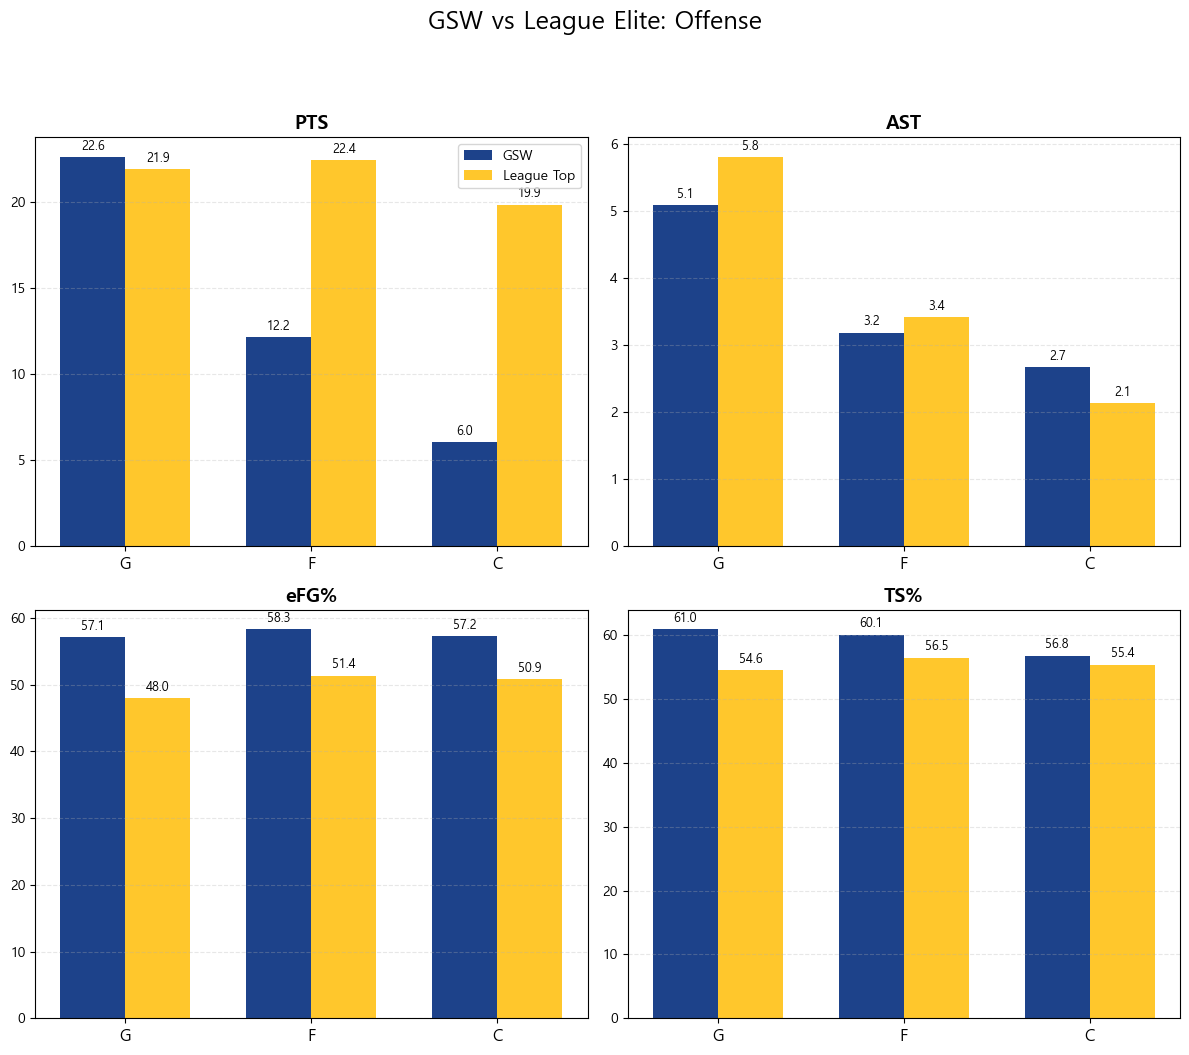

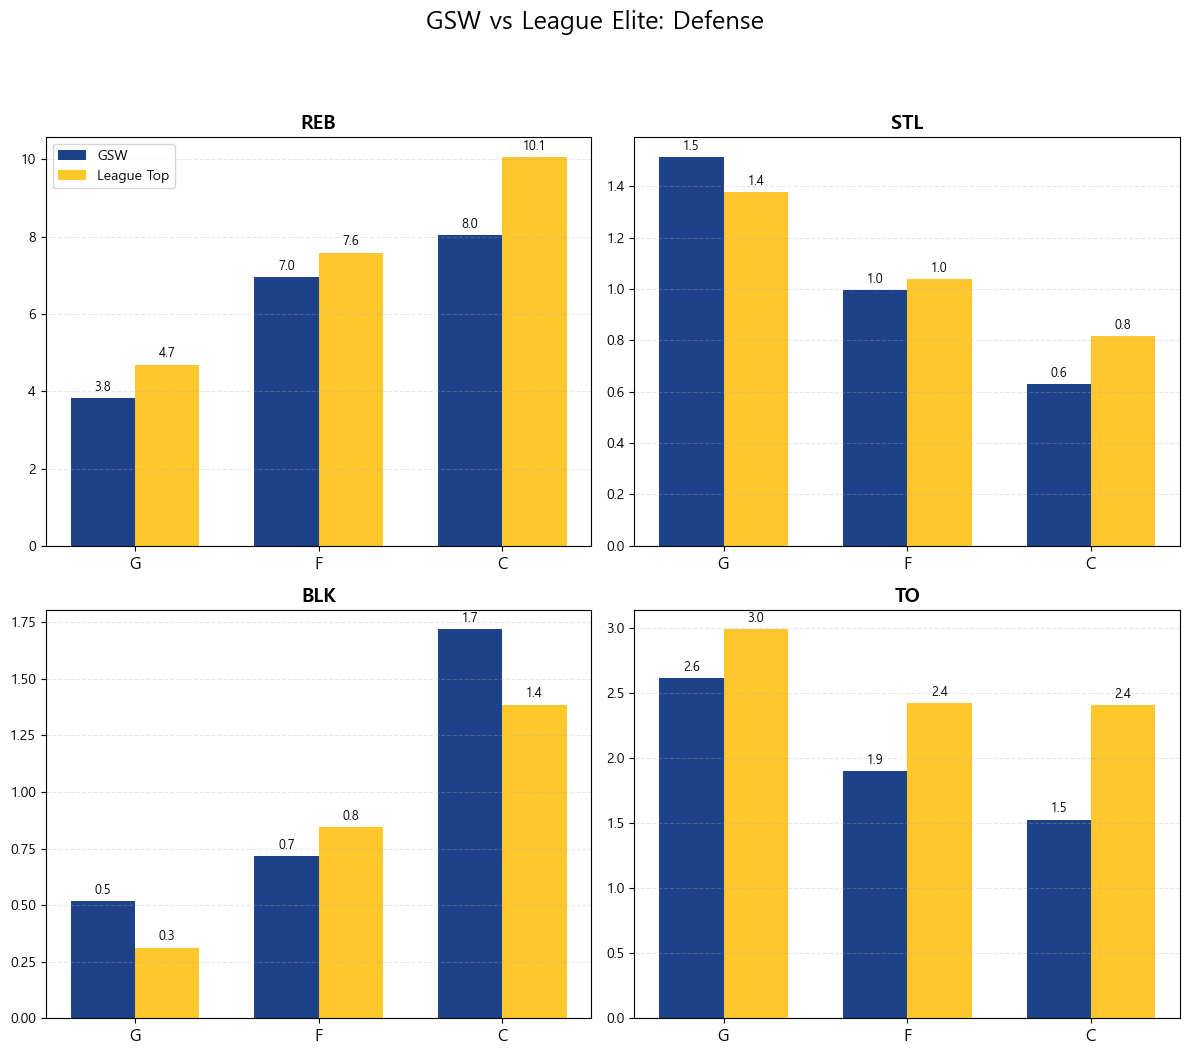

In [33]:
gsw_mean = gsw_starters.groupby('START_POSITION').mean(numeric_only=True)
league_mean = league_top.groupby('START_POSITION').mean(numeric_only=True)

def plot_comparison(gsw_data, league_data, columns, title):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    positions = ['G', 'F', 'C']

    gsw_blue = '#1D428A'
    gsw_yellow = '#FFC72C'
    gsw_slate = '#26282A'

    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]

        gsw_vals = [gsw_data.loc[pos, col] for pos in positions]
        league_vals = [league_data.loc[pos, col] for pos in positions]

        x = np.arange(len(positions))
        width = 0.35

        rects1 = ax.bar(x - width/2, gsw_vals, width, label='GSW', color=gsw_blue)
        rects2 = ax.bar(x + width/2, league_vals, width, label='League Top', color=gsw_yellow)

        ax.set_title(col, fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(positions, fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        ax.bar_label(rects1, padding=3, fmt='%.1f', fontsize=9)
        ax.bar_label(rects2, padding=3, fmt='%.1f', fontsize=9)

        if i == 0:
            ax.legend()

    fig.suptitle(title, fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()

Off_cols = ['PTS', 'AST', 'eFG%', 'TS%']
plot_comparison(gsw_mean, league_mean, Off_cols, 'GSW vs League Elite: Offense')

Def_cols = ['REB', 'STL', 'BLK', 'TO']
plot_comparison(gsw_mean, league_mean, Def_cols, 'GSW vs League Elite: Defense')

- G 포지션의 지표들은 단순히 잘하는 수준을 넘어, 리그 상위 선수들보다 우위에 있다고 볼 수 있다.
- F, C 포지션은 득점 볼륨 자체는 낮을 수 있지만 eFG%, TS% 지표에서는 높은 수치를 기록하는 것을 보아 효율적이고 가치 있는 득점을 하고 있다.
- C 포지션은 직접 득점보다 동료에게 도움을 주는 역할을 수행하는 것을 알 수 있다.
- BLK이 높다는 것은 상대 슈팅을 막아 실점 위기를 잘 막았다라는 것을 의미함.
- REB가 낮다는 것은 상대적 신장의 열세 혹은 스몰 라인업 운영인가?
--> 제공권 보완이 필요할지, 현재의 기조를 유지할지에 대한 의사결정 포인트.
- TO 비율이 낮은 것은 공격 찬스에서 실수를 하지 않음을 의미 득점까지 연결할 확률을 높힘.


In [34]:
df_2014 = df[df['SEASON'] == 2014]

bench_df = df_2014[df_2014['START_POSITION'] == 'bench']

sub_avg = bench_df.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION'])[basic_stats].mean(numeric_only=True).reset_index()

bench_counts = bench_df.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION'])['GAME_ID'].count().reset_index(name='GAME_COUNT')
sub_avg = pd.merge(sub_avg, bench_counts, on=['PLAYER_NAME', 'TEAM_ABBREVIATION'])

sub_avg = sub_avg[sub_avg['GAME_COUNT'] >= 30]

sub_avg['eFG%'] = (sub_avg['FGM'] + 0.5 * sub_avg['FG3M']) / sub_avg['FGA'] * 100
sub_avg['TS%'] = sub_avg['PTS'] / (2 * (sub_avg['FGA'] + 0.44 * sub_avg['FTA'])) * 100

gsw_sub = sub_avg[sub_avg['TEAM_ABBREVIATION'] == 'GSW']
league_sub = sub_avg[sub_avg['TEAM_ABBREVIATION'] != 'GSW']

cols = ['PTS', 'AST', 'REB', 'TS%', 'eFG%', 'PLUS_MINUS']

print(f"GSW 벤치 평균 (대상: {len(gsw_sub)}명)")
print(gsw_sub[cols].mean(numeric_only=True).round(2))

print(f"리그 전체 벤치 평균 (대상: {len(league_sub)}명)")
print(league_sub[cols].mean(numeric_only=True).round(2))

GSW 벤치 평균 (대상: 8명)
PTS            5.55
AST            1.38
REB            2.64
TS%           50.90
eFG%          47.61
PLUS_MINUS     0.89
dtype: float64
리그 전체 벤치 평균 (대상: 221명)
PTS            6.05
AST            1.30
REB            2.81
TS%           51.89
eFG%          48.42
PLUS_MINUS    -0.42
dtype: float64


### 결론 인사이트
- 전 포지션에서 압도적인 슈퍼팀은 아니지만, G 포지션만큼은 리그 내 대체 불가능한 최상위 경쟁력을 보유.
- 가드진의 파워를 극대화하기 위한 나머지 포지션의 철저한 시스템 농구.

### 단장 관점에서 인사이트 연관
전 포지션이 경쟁력이 있었냐는 질문에는 no 라고 답하지만, G의 경쟁력은 최상위 경쟁력이다. 또, 전 포지션의 높은 TS%는 개인이 아닌 팀 효율성을 극대화한 시스템 농구라고 말하고 싶다.
 팀에게 높이 보강 or 현재 시스템 유지 라는 의사결정에 도움을 주는 제안을 하자면 TS%가 높고 에너지 레벨이 높은 선수를 보강하거나 활동량이 좋은 장신 윙 자원으로 팀 전체의 시스템을 잃지 않는 선택으로 가야한다.

### 김규열

#### 활약은 어떻게 정의할 것인가?
- 활약: 선수의 득점(PTS, 보조지표로 FG_PCT / FG3_PCT / FT_PCT사용)
- 활약: PLUS_MINUS, 전반적인 영향력.
- PLUS-MINUS는 선수가 코트에 있을 때 팀의 득실점 차이를 직접적으로 반영하기 때문에, 박스스코어 기반 지표 중에서는 선수의 전반적인 경기 영향력을 가장 직관적으로 관찰할 수 있는 지표입니다. 특히나, 득점, 수비, 볼 흐름 등 개별 스탯으로 분리하기 어려운 요소들이 모두 반영된 상태에서 팀이 얼마나 더 잘했는지를 보여줍니다.
- 선수: MIN을 기준으로 많은 선수 선택(경기에 적은 시간을 뛴 선수는 분석결과를 흐릴 수 있음)
- 비교년도와 비교대상년도들에 둘 다 존재하는 선수의 경우 비교가 가능하다.
- 본 분석에서는 ‘활약’을 단일 정의로 한정하지 않고, 득점, 전반적 영향력의 두 가지 정의에서 실시한다.

#### 활약을 선수의 득점으로 정의하고 분석시행

In [67]:
# GSW_details 테이블 생성
GSW_details = clean_details[clean_details["TEAM_ABBREVIATION"]=="GSW"]
GSW_details

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_ID,PLAYER_NAME,START_POSITION,MIN,PLUS_MINUS,FGM,FGA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,MIN_DECIMAL,PLUS_MINUS_AVAILABLE
153,22200470,1610612744,GSW,1630228,Jonathan Kuminga,F,30:15,-23.0,1.0,9.0,...,4.0,6.0,4.0,1.0,0.0,4.0,2.0,4.0,30.25,True
154,22200470,1610612744,GSW,203110,Draymond Green,F,23:16,-27.0,1.0,2.0,...,4.0,4.0,6.0,0.0,0.0,2.0,2.0,2.0,23.266667,True
155,22200470,1610612744,GSW,1626172,Kevon Looney,C,16:55,-10.0,2.0,5.0,...,3.0,7.0,1.0,0.0,0.0,1.0,3.0,6.0,16.916667,True
156,22200470,1610612744,GSW,1630541,Moses Moody,G,30:55,-14.0,7.0,11.0,...,1.0,1.0,3.0,1.0,0.0,0.0,3.0,17.0,30.916667,True
157,22200470,1610612744,GSW,1629673,Jordan Poole,G,26:11,-31.0,4.0,17.0,...,1.0,1.0,2.0,1.0,0.0,7.0,1.0,13.0,26.183333,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665746,21200010,1610612744,GSW,201575,Brandon Rush,NaN,23:30,3.0,6.0,9.0,...,1.0,1.0,2.0,0.0,0.0,3.0,5.0,14.0,23.5,True
665747,21200010,1610612744,GSW,101127,Jarrett Jack,NaN,29:32,8.0,3.0,7.0,...,3.0,3.0,7.0,1.0,0.0,4.0,2.0,10.0,29.533333,True
665748,21200010,1610612744,GSW,201171,Carl Landry,NaN,22:56,13.0,7.0,9.0,...,1.0,6.0,1.0,1.0,0.0,2.0,0.0,17.0,22.933333,True
665749,21200010,1610612744,GSW,2210,Richard Jefferson,NaN,13:17,7.0,0.0,2.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,13.283333,True


In [68]:
# 시즌별 게임 아이디 테이블 생성
SEASON_games =clean_games[["GAME_ID","SEASON",'GAME_DATE_EST']]

In [69]:
# GSW_details 테이블에 merge
GSW_details_merged = GSW_details.merge(SEASON_games, on="GAME_ID", how="inner")
GSW_details_merged

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_ID,PLAYER_NAME,START_POSITION,MIN,PLUS_MINUS,FGM,FGA,...,AST,STL,BLK,TO,PF,PTS,MIN_DECIMAL,PLUS_MINUS_AVAILABLE,SEASON,GAME_DATE_EST
0,22200470,1610612744,GSW,1630228,Jonathan Kuminga,F,30:15,-23.0,1.0,9.0,...,4.0,1.0,0.0,4.0,2.0,4.0,30.25,True,2022,2022-12-21
1,22200470,1610612744,GSW,203110,Draymond Green,F,23:16,-27.0,1.0,2.0,...,6.0,0.0,0.0,2.0,2.0,2.0,23.266667,True,2022,2022-12-21
2,22200470,1610612744,GSW,1626172,Kevon Looney,C,16:55,-10.0,2.0,5.0,...,1.0,0.0,0.0,1.0,3.0,6.0,16.916667,True,2022,2022-12-21
3,22200470,1610612744,GSW,1630541,Moses Moody,G,30:55,-14.0,7.0,11.0,...,3.0,1.0,0.0,0.0,3.0,17.0,30.916667,True,2022,2022-12-21
4,22200470,1610612744,GSW,1629673,Jordan Poole,G,26:11,-31.0,4.0,17.0,...,2.0,1.0,0.0,7.0,1.0,13.0,26.183333,True,2022,2022-12-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18634,21200010,1610612744,GSW,201575,Brandon Rush,NaN,23:30,3.0,6.0,9.0,...,2.0,0.0,0.0,3.0,5.0,14.0,23.5,True,2012,2012-10-31
18635,21200010,1610612744,GSW,101127,Jarrett Jack,NaN,29:32,8.0,3.0,7.0,...,7.0,1.0,0.0,4.0,2.0,10.0,29.533333,True,2012,2012-10-31
18636,21200010,1610612744,GSW,201171,Carl Landry,NaN,22:56,13.0,7.0,9.0,...,1.0,1.0,0.0,2.0,0.0,17.0,22.933333,True,2012,2012-10-31
18637,21200010,1610612744,GSW,2210,Richard Jefferson,NaN,13:17,7.0,0.0,2.0,...,0.0,2.0,1.0,0.0,0.0,2.0,13.283333,True,2012,2012-10-31


In [70]:
# Deciding the Championship Year and comparing years.
champ_season = 2014
pre_seasons = [2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,2005,2004,2003]
GSW_Champyear= GSW_details_merged[GSW_details_merged["SEASON"]==champ_season]
GSW_Otheryear= GSW_details_merged[GSW_details_merged["SEASON"].isin(pre_seasons)]

In [71]:
# Getting the Team ID of Golden State Warriors.
if "TEAM_ABBREVIATION" in GSW_Champyear.columns:
    gsw_ids = GSW_Champyear.loc[GSW_Champyear["TEAM_ABBREVIATION"]=="GSW", "TEAM_ID"].dropna().unique()
else:
    gsw_ids = GSW_Champyear["TEAM_ID"].dropna().unique()
GSW_TEAM_ID = int(gsw_ids[0])

In [72]:
# Creating an opponent column for both years.
games_map = games[["GAME_ID","HOME_TEAM_ID","VISITOR_TEAM_ID"]].copy()

def add_opponent(df):
    out = df.merge(games_map, on="GAME_ID", how="left")
    out["OPP_TEAM_ID"] = np.where(
        out["HOME_TEAM_ID"] == GSW_TEAM_ID,
        out["VISITOR_TEAM_ID"],
        out["HOME_TEAM_ID"]
    )
    out["GSW_HOME_AWAY"] = np.where(out["HOME_TEAM_ID"] == GSW_TEAM_ID, "HOME", "AWAY")
    return out
GSW_Champyear = add_opponent(GSW_Champyear)
GSW_Otheryear = add_opponent(GSW_Otheryear)

In [73]:
# Defining the number of top players to consider.
TOP_N = 5
core_players = (
    GSW_Champyear.groupby(["PLAYER_ID","PLAYER_NAME"], as_index=False)["MIN_DECIMAL"].sum()
    .sort_values("MIN_DECIMAL", ascending=False)
    .head(TOP_N)
)
core_ids = core_players["PLAYER_ID"].unique()
Champ_core = GSW_Champyear[GSW_Champyear["PLAYER_ID"].isin(core_ids)].copy()
Other_core = GSW_Otheryear[GSW_Otheryear["PLAYER_ID"].isin(core_ids)].copy()

In [74]:
# Defining a function to summarize player performance against opponents.
def player_vs_opp_summary(df):
    return (
        df.groupby(["PLAYER_ID","PLAYER_NAME","OPP_TEAM_ID"], as_index=False)
          .agg(
              games_vs_opp=("GAME_ID","nunique"),
              pts_mean=("PTS","mean"),
              fg_mean=("FG_PCT","mean"),
              fg3_mean=("FG3_PCT","mean"),
              ft_mean=("FT_PCT","mean"),
          )
    )
Champ_player_opp = player_vs_opp_summary(Champ_core)
Other_player_opp = player_vs_opp_summary(Other_core)

In [75]:
# Players with at least 2 games against them.
MIN_GAMES_VS_OPP = 3
Champ_player_opp_over2 = Champ_player_opp[Champ_player_opp["games_vs_opp"] >= MIN_GAMES_VS_OPP].copy()
Other_player_opp_over2 = Other_player_opp[Other_player_opp["games_vs_opp"] >= MIN_GAMES_VS_OPP].copy()

In [76]:
Champ_player_opp_over2.head()

,PLAYER_ID,PLAYER_NAME,OPP_TEAM_ID,games_vs_opp,pts_mean,fg_mean,fg3_mean,ft_mean
2,2738,Andre Iguodala,1610612739,8,14.00,0.529000,0.433625,0.44775
3,2738,Andre Iguodala,1610612740,8,8.50,0.390875,0.156250,0.45000
5,2738,Andre Iguodala,1610612742,4,7.25,0.383500,0.194250,0.00000
6,2738,Andre Iguodala,1610612743,4,5.00,0.395750,0.250000,0.33325
7,2738,Andre Iguodala,1610612745,10,6.90,0.462600,0.233300,0.26000


In [77]:
Other_player_opp_over2.head()

,PLAYER_ID,PLAYER_NAME,OPP_TEAM_ID,games_vs_opp,pts_mean,fg_mean,fg3_mean,ft_mean
6,2738,Andre Iguodala,1610612743,3,7.000000,0.325333,0.166667,0.500000
8,2738,Andre Iguodala,1610612746,11,12.363636,0.543091,0.453000,0.530909
9,2738,Andre Iguodala,1610612747,3,5.333333,0.282000,0.277667,0.416667
18,2738,Andre Iguodala,1610612756,3,9.000000,0.546333,0.666667,0.277667
19,2738,Andre Iguodala,1610612757,3,10.333333,0.518333,0.333333,0.000000


In [78]:
# Compute “stability across opponents” per player
def opponent_stability(df_player_opp):
    return (
        df_player_opp.groupby(["PLAYER_ID","PLAYER_NAME"], as_index=False)
            .agg(
                num_opponents_faced=("OPP_TEAM_ID","nunique"),
                pts_전체_평균=("pts_mean","mean"),
                pts_표준편차=("pts_mean","std"),
                pts_최소값=("pts_mean","min"),
                pts_최대값=("pts_mean","max"),
                fg_표준편차=("fg_mean","std"),
                fg3_표준편차=("fg3_mean","std"),
                ft_표준편차=("ft_mean","std"),
            )
    )
Champ_stability = opponent_stability(Champ_player_opp_over2)
Other_stability = opponent_stability(Other_player_opp_over2)

Champ_stability.head()

,PLAYER_ID,PLAYER_NAME,num_opponents_faced,pts_전체_평균,pts_표준편차,pts_최소값,pts_최대값,fg_표준편차,fg3_표준편차,ft_표준편차
0,2738,Andre Iguodala,16,8.106597,2.179680,5.000000,14.0,0.081866,0.109021,0.244719
1,201939,Stephen Curry,16,24.522569,4.707187,15.000000,33.0,0.049535,0.090055,0.132845
2,202691,Klay Thompson,16,21.084573,3.646785,12.666667,27.5,0.055635,0.074758,0.213537
3,203084,Harrison Barnes,16,10.059896,2.062597,5.800000,14.0,0.090868,0.111295,0.166154
4,203110,Draymond Green,16,11.105903,2.438108,7.500000,15.8,0.071202,0.141007,0.171769


In [79]:
# Plot style change
plt.rcdefaults()
plt.style.use("seaborn-v0_8-white")
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["axes.prop_cycle"] = cycler(color=["#1D428A", "#FFC72C", "#26282A", "#E03A3E"])

<Figure size 1000x600 with 0 Axes>

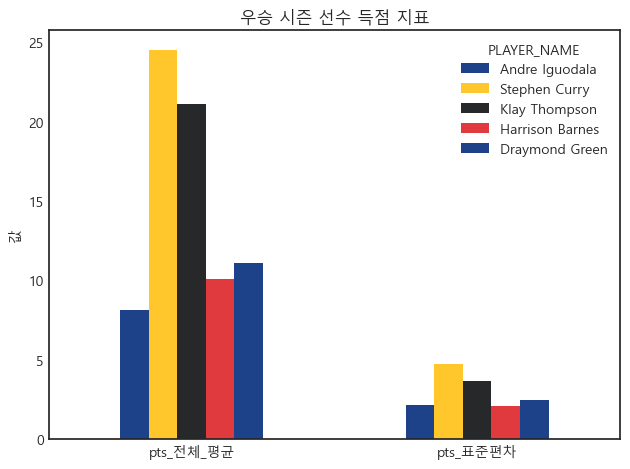

In [80]:
Champ_plot = Champ_stability[["PLAYER_NAME", "pts_전체_평균", "pts_표준편차"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10, 6))
Champ_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("우승 시즌 선수 득점 지표")
plt.tight_layout()
plt.show()

- 상대별 평균 득점의 평균(pts_mean_overall)과 상대별 평균 득점의 표준편차(pts_std)를 비교해봤을 때 상대적으로 pts_std가 큰 것을 볼 수 있음.
- 이는 선수의 활약이 상대팀이 달라짐에 따라 안정적이지 못한다고 해석해 볼 수 있음.

<Figure size 1000x600 with 0 Axes>

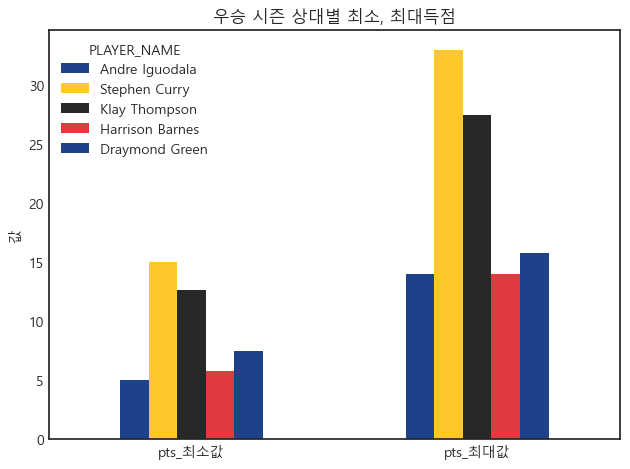

In [81]:
Champ_plot = Champ_stability[["PLAYER_NAME", "pts_최소값","pts_최대값"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10, 6))
Champ_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("우승 시즌 상대별 최소, 최대득점")
plt.tight_layout()
plt.show()

- 상대별 평균득점의 최소점과 최대점이 차이가 생각보다 나는 것처럼 보인다.
- 이는 선수의 활약이 상대에 의존이 큰 매치업이 존재한다는 것을 볼 수 있다.

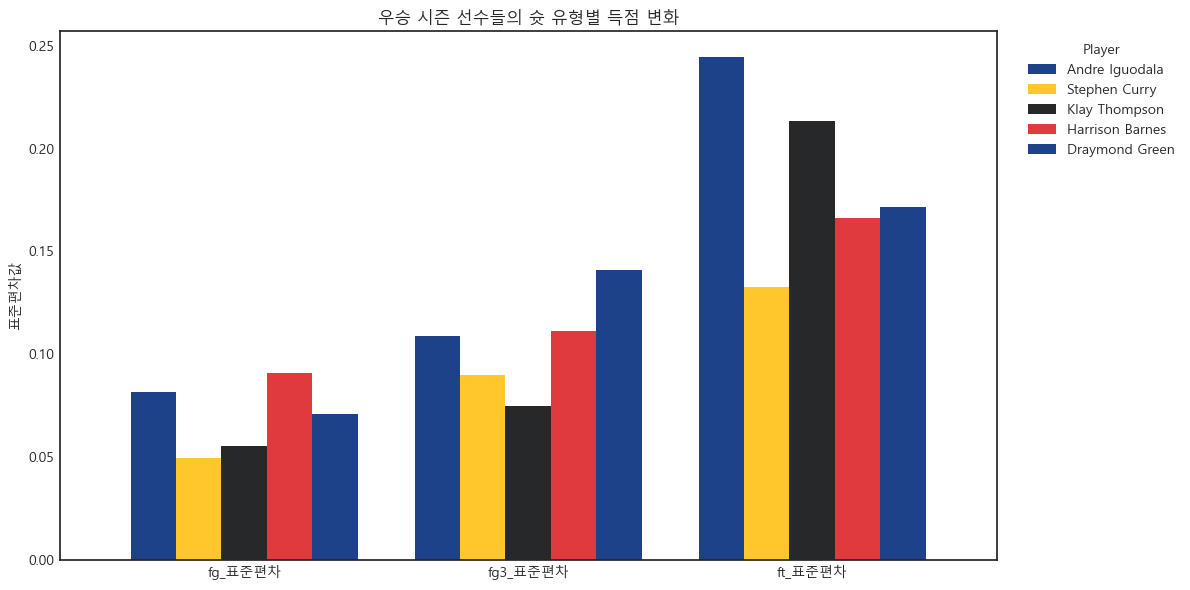

In [82]:
Champ_plot = Champ_stability[
    ["PLAYER_NAME", "fg_표준편차", "fg3_표준편차", "ft_표준편차"]
].set_index("PLAYER_NAME")
fig, ax = plt.subplots(figsize=(12, 6))
Champ_plot.T.plot(
    kind="bar",
    ax=ax,
    width=0.8
)
ax.set_ylabel("표준편차값")
ax.set_title("우승 시즌 선수들의 슛 유형별 득점 변화")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ax.legend(
    title="Player",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()

- 대체적으로 상대팀별 field goal 평균과 3점슛 평균, 자유투 평균의 분산은 작은 것으로 확인할 수 있다.
- 이는 선수들이 상대방이 변화하더라도, 안정적인 field goal, 3점슛, 자유투를 했다고 해석해볼 수 있다.

In [83]:
Other_stability.head()

,PLAYER_ID,PLAYER_NAME,num_opponents_faced,pts_전체_평균,pts_표준편차,pts_최소값,pts_최대값,fg_표준편차,fg3_표준편차,ft_표준편차
0,2738,Andre Iguodala,8,9.024621,2.309514,5.333333,12.363636,0.107327,0.181526,0.224874
1,201939,Stephen Curry,29,20.514718,3.153171,15.000000,28.125000,0.037863,0.078727,0.123028
2,202691,Klay Thompson,29,15.699281,2.680660,9.800000,20.000000,0.043618,0.095625,0.213573
3,203084,Harrison Barnes,29,9.408456,2.370699,5.000000,14.000000,0.074153,0.138973,0.163405
4,203110,Draymond Green,29,4.744875,1.526864,1.250000,7.750000,0.098244,0.117945,0.191441


<Figure size 1000x600 with 0 Axes>

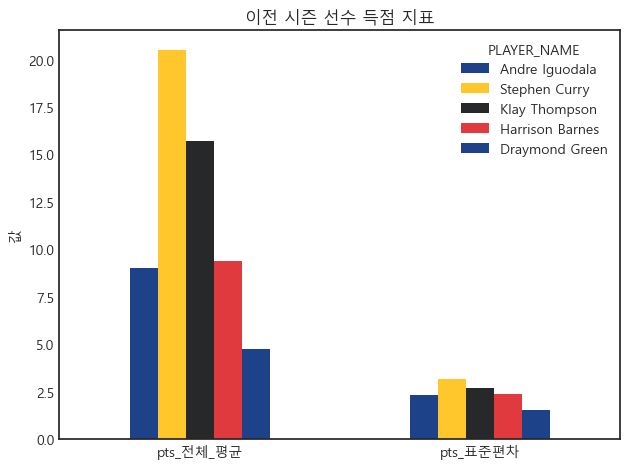

In [84]:
Other_plot = Other_stability[["PLAYER_NAME","pts_전체_평균", "pts_표준편차"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10, 6))
Other_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("이전 시즌 선수 득점 지표")
plt.tight_layout()
plt.show()

- 상대별 평균 득점의 평균(pts_mean_overall)과 상대별 평균 득점의 표준편차(pts_std)를 비교해봤을 때 상대적으로 pts_std가 작은 것을 볼 수 있음.
- 이는 선수의 활약이 상대팀이 달라짐에도 비교적 안정적이라고 해석해볼 수 있다.

<Figure size 1200x1200 with 0 Axes>

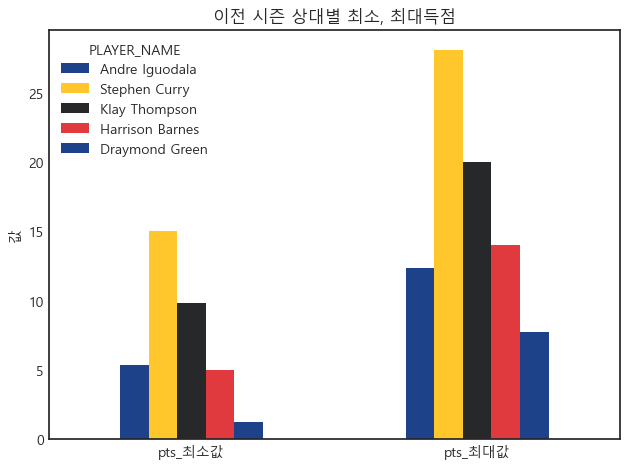

In [85]:
Other_plot = Other_stability[["PLAYER_NAME", "pts_최소값","pts_최대값"]].set_index("PLAYER_NAME")
plt.figure(figsize=(12,12))
Other_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("이전 시즌 상대별 최소, 최대득점")
plt.tight_layout()
plt.show()

- 상대별 평균득점의 최소점과 최대점이 차이가 생각보다 크게 나는 것처럼 보인다.
- 이는 선수의 활약이 상대에 의존이 큰 매치업이 존재한다는 것을 볼 수 있다.

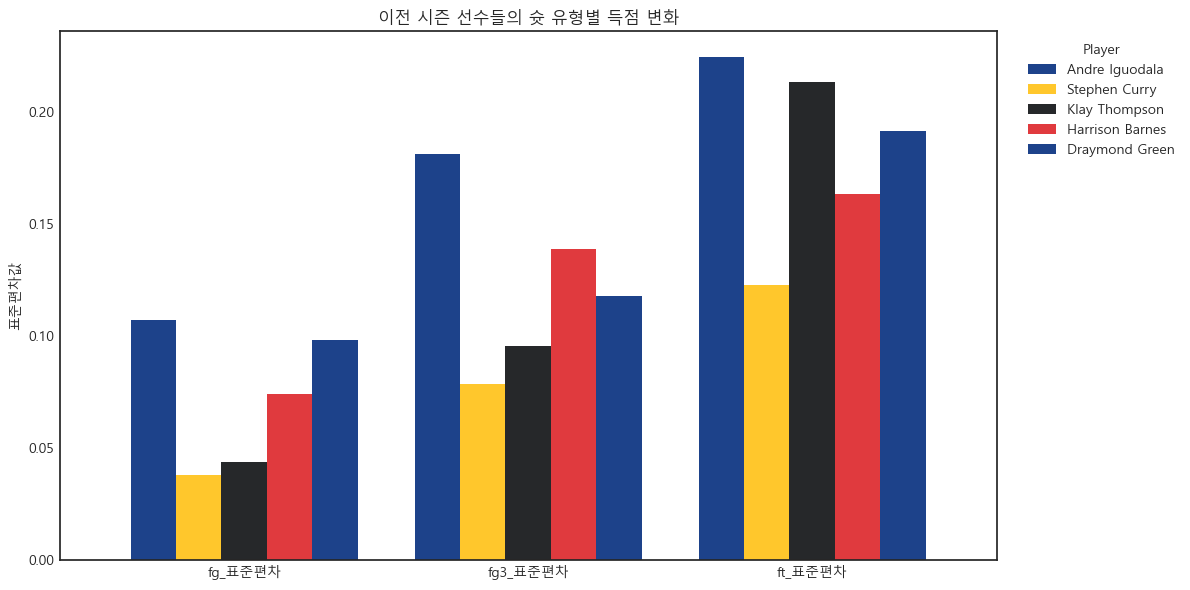

In [86]:
Other_plot = Other_stability[
    ["PLAYER_NAME", "fg_표준편차", "fg3_표준편차", "ft_표준편차"]
].set_index("PLAYER_NAME")
fig, ax = plt.subplots(figsize=(12, 6))
Other_plot.T.plot(
    kind="bar",
    ax=ax,
    width=0.8
)
ax.set_ylabel("표준편차값")
ax.set_title("이전 시즌 선수들의 슛 유형별 득점 변화")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ax.legend(
    title="Player",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

- 대체적으로 상대팀별 field goal 평균과 3점슛 평균, 자유투 평균의 분산은 작은 것으로 확인할 수 있다.
- 이는 선수들이 상대방이 변화하더라도, 안정적인 field goal, 3점슛, 자유투를 했다고 해석해볼 수 있다.

In [87]:
# Now compare the results of other years and champ year
compare = (
    Champ_stability.merge(
        Other_stability,
        on=["PLAYER_ID","PLAYER_NAME"],
        how="inner",
        suffixes=("_champ","_other")
    )
)
compare["delta_pts_표준편차"] = compare["pts_표준편차_champ"] - compare["pts_표준편차_other"]
compare["delta_fg_표준편차"] = compare["fg_표준편차_champ"] - compare["fg_표준편차_other"]
compare["delta_fg3_표준편차"] = compare["fg3_표준편차_champ"] - compare["fg3_표준편차_other"]
compare["delta_ft_표준편차"] = compare["ft_표준편차_champ"] - compare["ft_표준편차_other"]
compare

,PLAYER_ID,PLAYER_NAME,num_opponents_faced_champ,pts_전체_평균_champ,pts_표준편차_champ,pts_최소값_champ,pts_최대값_champ,fg_표준편차_champ,fg3_표준편차_champ,ft_표준편차_champ,...,pts_표준편차_other,pts_최소값_other,pts_최대값_other,fg_표준편차_other,fg3_표준편차_other,ft_표준편차_other,delta_pts_표준편차,delta_fg_표준편차,delta_fg3_표준편차,delta_ft_표준편차
0,2738,Andre Iguodala,16,8.106597,2.179680,5.000000,14.0,0.081866,0.109021,0.244719,...,2.309514,5.333333,12.363636,0.107327,0.181526,0.224874,-0.129834,-0.025461,-0.072505,0.019845
1,201939,Stephen Curry,16,24.522569,4.707187,15.000000,33.0,0.049535,0.090055,0.132845,...,3.153171,15.000000,28.125000,0.037863,0.078727,0.123028,1.554016,0.011672,0.011328,0.009818
2,202691,Klay Thompson,16,21.084573,3.646785,12.666667,27.5,0.055635,0.074758,0.213537,...,2.680660,9.800000,20.000000,0.043618,0.095625,0.213573,0.966125,0.012018,-0.020867,-0.000036
3,203084,Harrison Barnes,16,10.059896,2.062597,5.800000,14.0,0.090868,0.111295,0.166154,...,2.370699,5.000000,14.000000,0.074153,0.138973,0.163405,-0.308102,0.016715,-0.027678,0.002750
4,203110,Draymond Green,16,11.105903,2.438108,7.500000,15.8,0.071202,0.141007,0.171769,...,1.526864,1.250000,7.750000,0.098244,0.117945,0.191441,0.911245,-0.027042,0.023061,-0.019672


<Figure size 1200x1200 with 0 Axes>

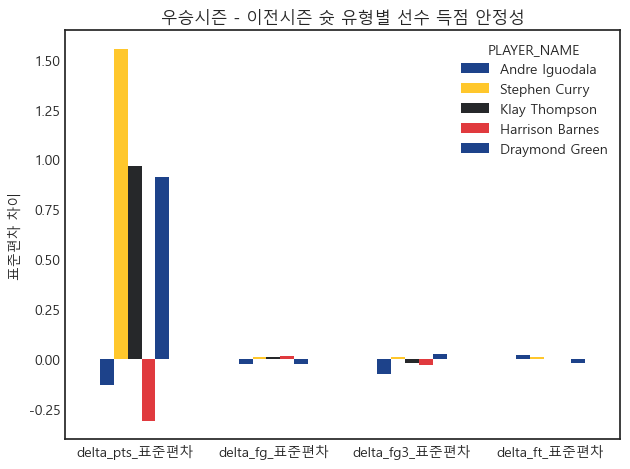

In [88]:
compare_plot = compare[["PLAYER_NAME", "delta_pts_표준편차", "delta_fg_표준편차", "delta_fg3_표준편차", "delta_ft_표준편차"]].set_index("PLAYER_NAME")
plt.figure(figsize=(12,12))
compare_plot.T.plot(kind="bar", rot=0)
plt.ylabel("표준편차 차이")
plt.title("우승시즌 - 이전시즌 슛 유형별 선수 득점 안정성")
plt.tight_layout()
plt.show()

- 2015년 시즌과 이전 시즌을 비교했을 때 대부분 선수가 상대별 득점 평균의 분산이 증가했다고 알 수 있다.
- 이는 선수의 활약이 이전시즌과 비교해, 우승시즌에는 상대팀이 달라지면 안정적이지 못하다는 것을 볼 수 있다.
- 또한 field goal 평균과 3점슛 평균, 자유투 평균의 분산에 변화가 적다는 것을 볼 수 있다.
- 안정적으로 field goal, 3점슛, 자유투를 유지하였다는 것으로, 위에서 볼 수 있었던 득점 안정성의 부재는 선수의 기량의 문제가 아니라는 것을 확인해볼 수 있다.

#### 활약을 선수의 PLUS_MINUS로 정의하고 분석시행

In [ ]:
# Defining the number of top players to consider.
# TOP_N = 5
# core_players = (
#     GSW_Champyear.groupby(["PLAYER_ID","PLAYER_NAME"], as_index=False)["MIN"].sum()
#     .sort_values("MIN", ascending=False)
#     .head(TOP_N)
# )
# core_ids = core_players["PLAYER_ID"].unique()
# Champ_core = GSW_Champyear[GSW_Champyear["PLAYER_ID"].isin(core_ids)].copy()
# Other_core = GSW_Otheryear[GSW_Otheryear["PLAYER_ID"].isin(core_ids)].copy()
# 이어지는 코드의 이전코드를 보기 위해 주석으로 둠.

In [89]:
# Getting the player vs opponent summary with plus-minus
def player_vs_opp_summary_pm(df):
    return (
        df.groupby(["PLAYER_ID","PLAYER_NAME","OPP_TEAM_ID"], as_index=False)
          .agg(
              games_vs_opp=("GAME_ID","nunique"),
              pm_mean=("PLUS_MINUS","mean"),))
Champ_player_opp_pm = player_vs_opp_summary_pm(Champ_core)
Other_player_opp_pm = player_vs_opp_summary_pm(Other_core)

In [90]:
# Limiting to players with at least 2 games against them.
MIN_GAMES_VS_OPP = 2
Champ_player_opp_pm_over2 = Champ_player_opp_pm[Champ_player_opp_pm["games_vs_opp"] >= MIN_GAMES_VS_OPP].copy()
Other_player_opp_pm_over2 = Other_player_opp_pm[Other_player_opp_pm["games_vs_opp"] >= MIN_GAMES_VS_OPP].copy()

In [91]:
Champ_player_opp_pm_over2.head()

,PLAYER_ID,PLAYER_NAME,OPP_TEAM_ID,games_vs_opp,pm_mean
0,2738,Andre Iguodala,1610612737,2,9.500
1,2738,Andre Iguodala,1610612738,2,2.500
2,2738,Andre Iguodala,1610612739,8,9.375
3,2738,Andre Iguodala,1610612740,8,0.250
4,2738,Andre Iguodala,1610612741,2,0.000


In [92]:
Other_player_opp_pm_over2.head()

,PLAYER_ID,PLAYER_NAME,OPP_TEAM_ID,games_vs_opp,pm_mean
0,2738,Andre Iguodala,1610612737,2,14.5
1,2738,Andre Iguodala,1610612738,2,18.0
2,2738,Andre Iguodala,1610612739,2,8.0
3,2738,Andre Iguodala,1610612740,2,19.0
4,2738,Andre Iguodala,1610612741,2,9.5


In [93]:
# Calculating player stability based on plus-minus
def opponent_stability_pm(df_player_opp_pm):
    return (
        df_player_opp_pm.groupby(["PLAYER_ID","PLAYER_NAME"], as_index=False)
          .agg(
              num_opponents_faced=("OPP_TEAM_ID","nunique"),
              pm_전체_평균=("pm_mean","mean"),
              pm_표준편차=("pm_mean","std"),
              pm_최소값=("pm_mean","min"),
              pm_최대값=("pm_mean","max"),
          )
    )
Champ_stability_pm = opponent_stability_pm(Champ_player_opp_pm_over2)
Other_stability_pm = opponent_stability_pm(Other_player_opp_pm_over2)

In [94]:
Champ_stability_pm.head()

,PLAYER_ID,PLAYER_NAME,num_opponents_faced,pm_전체_평균,pm_표준편차,pm_최소값,pm_최대값
0,2738,Andre Iguodala,27,5.653601,6.582286,-5.500000,26.0
1,201939,Stephen Curry,28,10.903274,6.947581,-4.000000,29.0
2,202691,Klay Thompson,28,9.970451,7.066339,-4.333333,31.5
3,203084,Harrison Barnes,29,6.775383,7.080955,-3.500000,35.5
4,203110,Draymond Green,28,10.708036,7.732072,-7.333333,33.0


<Figure size 1000x600 with 0 Axes>

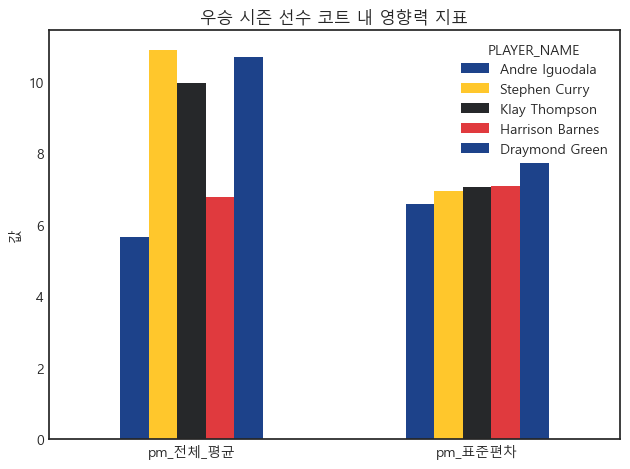

In [95]:
Champ_pm_plot = Champ_stability_pm[["PLAYER_NAME", "pm_전체_평균", "pm_표준편차"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10, 6))
Champ_pm_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("우승 시즌 선수 코트 내 영향력 지표")
plt.tight_layout()
plt.show()

- 상대별 평균 PLUS_MINUS(pm_mean_overall)과 상대별 평균 PLUS_MINUS(pm_std)를 비교해봤을 때 상대적으로 pm_std가 큰 것을 볼 수 있음.
- 이는 선수의 활약이 상대팀이 달라짐에 따라 안정적이지 못한다고 해석해 볼 수 있음.

<Figure size 1000x600 with 0 Axes>

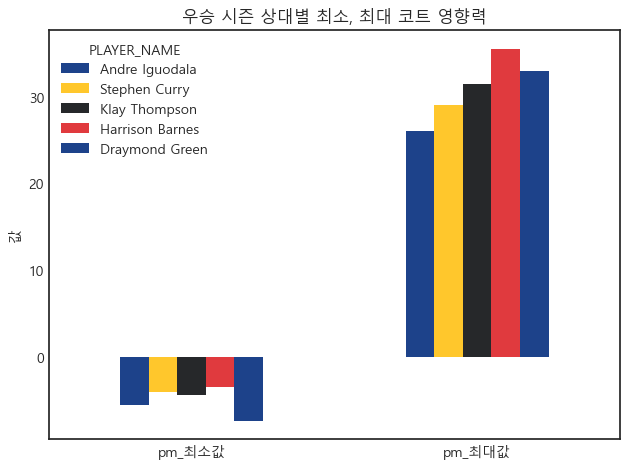

In [96]:
# Plot to see the pm_min, pm_max comparison
Champ_pm_plot= Champ_stability_pm[["PLAYER_NAME", "pm_최소값", "pm_최대값"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10, 6))
Champ_pm_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("우승 시즌 상대별 최소, 최대 코트 영향력")
plt.tight_layout()
plt.show()

- 상대별 평균 PLUS_MINUS의 최소점과 최대점이 차이가 생각보다 크게 나는 것처럼 보인다.
- 이는 선수의 활약이 상대에 의존이 큰 매치업이 존재한다는 것을 볼 수 있다.

In [97]:
Other_stability_pm.head()

,PLAYER_ID,PLAYER_NAME,num_opponents_faced,pm_전체_평균,pm_표준편차,pm_최소값,pm_최대값
0,2738,Andre Iguodala,24,9.228220,8.741406,-2.666667,37.000000
1,201939,Stephen Curry,29,2.107520,4.564718,-4.928571,11.230769
2,202691,Klay Thompson,29,2.793144,5.092806,-8.200000,11.600000
3,203084,Harrison Barnes,29,0.519089,4.654048,-8.000000,11.500000
4,203110,Draymond Green,29,0.428515,3.949635,-9.750000,7.375000


<Figure size 1000x600 with 0 Axes>

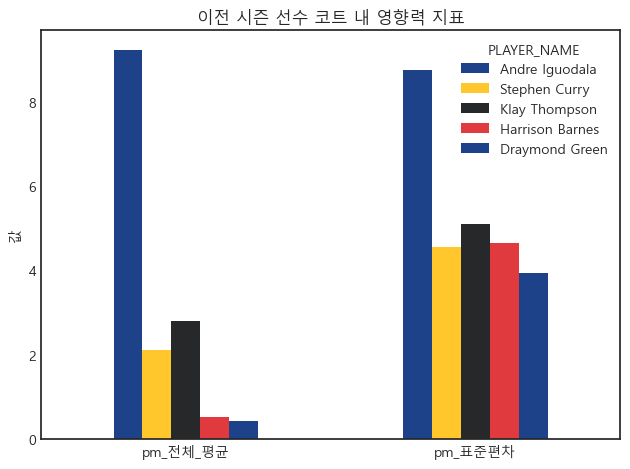

In [98]:
# Plot to see the pm_mean_overall comparison
Other_pm_plot= Other_stability_pm[["PLAYER_NAME", "pm_전체_평균", "pm_표준편차"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10, 6))
Other_pm_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("이전 시즌 선수 코트 내 영향력 지표")
plt.tight_layout()
plt.show()

- 상대별 평균 PLUS_MINUS(pm_mean_overall)과 상대별 평균 PLUS_MINUS(pm_std)를 비교해봤을 때 상대적으로 pm_std가 큰 것을 볼 수 있음.
- 이는 선수의 활약이 상대팀이 달라짐에 따라 안정적이지 못한다고 해석해 볼 수 있음.

<Figure size 1000x600 with 0 Axes>

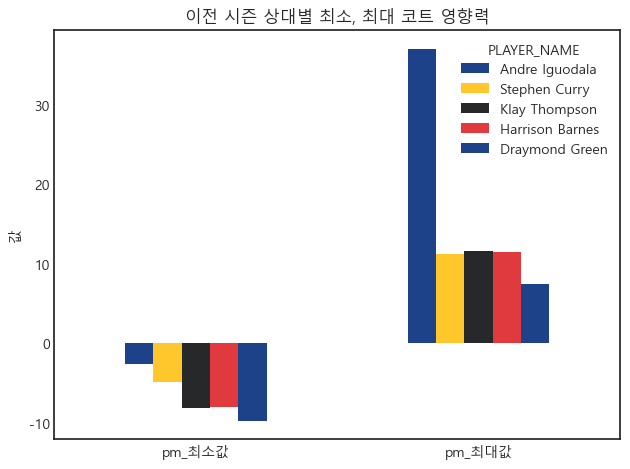

In [99]:
# Plot to see the pm_min, pm_max comparison
Other_pm_plot= Other_stability_pm[["PLAYER_NAME", "pm_최소값", "pm_최대값"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10, 6))
Other_pm_plot.T.plot(kind="bar", rot=0)
plt.ylabel("값")
plt.title("이전 시즌 상대별 최소, 최대 코트 영향력")
plt.tight_layout()
plt.show()

- 상대별 평균 PLUS_MINUS의 최소점과 최대점이 차이가 생각보다 크게 나는 것처럼 보인다.
- 이는 선수의 활약이 상대에 의존이 큰 매치업이 존재한다는 것을 볼 수 있다.

In [100]:
# Compare Champ vs Other season player stability
compare_pm = (
    Champ_stability_pm.merge(
        Other_stability_pm,
        on=["PLAYER_ID","PLAYER_NAME"],
        how="inner",
        suffixes=("_champ","_other")
    )
)

compare_pm["delta_pm_표준편차"] = compare_pm["pm_표준편차_champ"] - compare_pm["pm_표준편차_other"]
compare_pm

,PLAYER_ID,PLAYER_NAME,num_opponents_faced_champ,pm_전체_평균_champ,pm_표준편차_champ,pm_최소값_champ,pm_최대값_champ,num_opponents_faced_other,pm_전체_평균_other,pm_표준편차_other,pm_최소값_other,pm_최대값_other,delta_pm_표준편차
0,2738,Andre Iguodala,27,5.653601,6.582286,-5.500000,26.0,24,9.228220,8.741406,-2.666667,37.000000,-2.159120
1,201939,Stephen Curry,28,10.903274,6.947581,-4.000000,29.0,29,2.107520,4.564718,-4.928571,11.230769,2.382863
2,202691,Klay Thompson,28,9.970451,7.066339,-4.333333,31.5,29,2.793144,5.092806,-8.200000,11.600000,1.973533
3,203084,Harrison Barnes,29,6.775383,7.080955,-3.500000,35.5,29,0.519089,4.654048,-8.000000,11.500000,2.426906
4,203110,Draymond Green,28,10.708036,7.732072,-7.333333,33.0,29,0.428515,3.949635,-9.750000,7.375000,3.782437


<Figure size 1000x600 with 0 Axes>

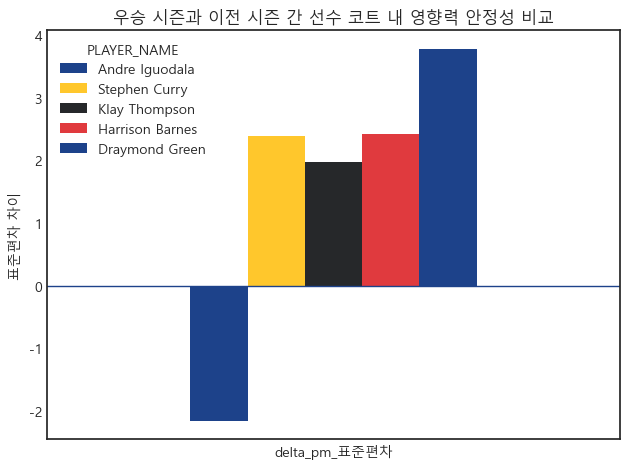

In [101]:
compare_pm_plot = compare_pm[["PLAYER_NAME","delta_pm_표준편차"]].set_index("PLAYER_NAME")
plt.figure(figsize=(10,6))
compare_pm_plot.T.plot(kind="bar", rot=0)
plt.axhline(0, linewidth=1)
plt.ylabel("표준편차 차이")
plt.title("우승 시즌과 이전 시즌 간 선수 코트 내 영향력 안정성 비교")
plt.tight_layout()
plt.show()

- 2015년 시즌과 이전 시즌을 비교했을 때 대부분 선수가 상대별 PLUS_MINUS의 분산이 증가했다고 알 수 있다.
- 이는 선수의 활약이 이전시즌과 비교해, 우승시즌에는 상대팀이 달라지면 안정적이지 못하다는 것을 볼 수 있다.

### 결론 인사이트
우승 시즌의 변화는 활약의 안정성 증가로 볼 수 없음을 확인할 수 있다.
오히려, 우승 시즌에는 성과가 상대팀에 따라 다르게 나타나는 경향으로 관찰되었다.

### 단장 관점에서 인사이트 연관
위의 분석을 통해 단장이 선수를 뽑을 때, 어떤 상대가 등장하든, 항상 잘하는 선수만 찾기보다는
특정 상대팀을 만났을 때 특히 강점을 보이는 선수들을 고려해보도록 조언을 할 수 있다.